# Import Modules

In [1]:
import numpy as np
import pandas as pd
import copy
from os import path
import os
from pathlib import Path
from typing import Union
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from Bio.PDB import PDBParser
import freesasa

# local modules
try:
    import mutagenesis_visualization.main.scripts.code_kwargs as code_kwargs
    import mutagenesis_visualization.main.scripts.code_utils as code_utils
except ModuleNotFoundError:
    import import_notebook
    import code_kwargs
    import code_utils

importing Jupyter notebook from code_kwargs.ipynb
importing Jupyter notebook from code_utils.ipynb


# Plotly plots

## Rank

In [2]:
def plot_rank_plotly(
    self,
    mode='pointmutant',
    outdf=False,
    output_html: Union[None, str, Path] = None,
    **kwargs
):
    '''
    Generate a plotly rank plot so every mutation/residue is sorted based 
    on enrichment score.

    Parameters
    ----------
    self : object from class *Screen*

    mode : str, default 'pointmutant'. 
        Alternative set to "mean" for the mean of each position.

    outdf : boolean, default False
        If set to true, will return the df with the rank of mutations.
        
    output_html : str, default None
        If you want to export the generated graph into html, add the path and name of the file.
        Example: 'path/filename.html'.
        
    **kwargs : other keyword arguments

    Returns
    ----------
    df : Pandas dataframe
    fig : plotly object

    '''
    # update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['figsize'] = kwargs.get('figsize', (4, 3))
    temp_kwargs['x_label'] = kwargs.get('x_label', 'Rank')
    temp_kwargs['y_label'] = kwargs.get('y_label', r'$∆E^i_x$')

    # Sort by enrichment scores
    df = self.dataframe.sort_values(by=['Score']).copy()

    # Chose mode:
    if mode == 'mean':
        df = df.groupby(by=['Position'], as_index=False).mean()
        df.sort_values(by=['Score'], inplace=True)
        df['Variant'] = df['Position']

    # Create figure
    fig = px.scatter(
        x=np.arange(len(df), 0, -1), y=df['Score'], text=df['Variant']
    )

    # Style
    pio.templates.default = "plotly_white"

    # Axes https://plotly.com/python/axes/
    fig.update_traces(
        mode="markers",
        hovertemplate=
        'Position: %{x}<br>Score: %{y}<br>Variant: %{text}<extra></extra>'
    )
    fig.update_xaxes(
        title_text=temp_kwargs['x_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True
    )
    fig.update_yaxes(
        title_text=temp_kwargs['y_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True
    )

    # Layout and title parameters https://plotly.com/python/figure-labels/
    fig.update_layout(
        width=temp_kwargs['figsize'][0] * 120,
        height=temp_kwargs['figsize'][1] * 120,
        font=dict(family="Arial, monospace", size=12, color="black"),
        title={
            'text': temp_kwargs['title'], 'xanchor': 'center', 'yanchor': 'top',
            'x': 0.5
        }
    )

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})

    # return dataframe
    if outdf:
        return df


# save file html
def _save_html(fig, output_html):
    '''save to html'''
    if output_html:
        fig.write_html(str(Path(output_html)))

## Scatter

In [3]:
def plot_scatter_plotly(
    self,
    obj2,
    mode='pointmutant',
    show_results=False,
    output_html: Union[None, str, Path] = None,
    **kwargs
):
    '''
    Generate a scatter plot between object and a second object of the 
    same class.

    Parameters
    ----------
    self : object from class *Screen*

    obj2 : object from class *Screen* to do the scatter with

    mode : str, default 'pointmutant'. 
        Alternative set to "mean" for the mean of each position.
    
    show_results : boolean, default False
        If set to true, will export the details of the linear fit.
        
    output_html : str, default None
        If you want to export the generated graph into html, add 
        the path and name of the file. Example: 'path/filename.html'.
        
    **kwargs : other keyword arguments

    Returns
    ----------
    fig : plotly object

    '''

    # update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['figsize'] = kwargs.get('figsize', (4, 3))

    # Chose mode:
    if mode == 'pointmutant':
        df = code_utils._process_bypointmutant(self, obj2)
    elif mode == 'mean':
        df = code_utils._process_meanresidue(self, obj2)
        df['Variant'] = df['Position']
    # raise error if mode is not "mean" or "pointmutant"

    # Style
    pio.templates.default = "plotly_white"

    # create figure
    fig = px.scatter(
        x=df['dataset_1'],
        y=df['dataset_2'],
        trendline="ols",
        trendline_color_override="red"
    )

    # Titles
    # hide text labels
    fig.update_traces(
        hovertext=df['Variant'],
        hovertemplate=
        'Score_x: %{x}<br>Score: %{y}<br>Score_y: %{hovertext}<extra></extra>'
    )
    fig.update_xaxes(
        title_text=temp_kwargs['x_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True
    )
    fig.update_yaxes(
        title_text=temp_kwargs['y_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True
    )

    # Layout and title parameters https://plotly.com/python/figure-labels/
    fig.update_layout(
        width=temp_kwargs['figsize'][0] * 120,
        height=temp_kwargs['figsize'][1] * 120,
        font=dict(family="Arial, monospace", size=12, color="black"),
        title={
            'text': temp_kwargs['title'], 'xanchor': 'center', 'yanchor': 'top',
            'x': 0.5
        }
    )

    if show_results:
        px.get_trendline_results(fig).px_fit_results.iloc[0].summary()

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})

## Heatmap

In [4]:
def plot_heatmap_plotly(
    self, output_html: Union[None, str, Path] = None, **kwargs
):
    '''
    Generate a plotly histogram plot.

    Parameters
    ----------
    self : object from class *Screen*
        
    output_html : str, default None
        If you want to export the generated graph into html, add the path and name of the file.
        Example: 'path/filename.html'.
        
    **kwargs : other keyword arguments

    Returns
    ----------
    fig : plotly object

    '''
    # update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['figsize'] = kwargs.get('figsize', (8, 3))
    temp_kwargs['x_label'] = kwargs.get('x_label', '')
    temp_kwargs['y_label'] = kwargs.get('y_label', '')

    # sort data by rows in specified order by user
    df = code_utils._df_rearrange(
        code_utils._add_SNV_boolean(self.dataframe_stopcodons.copy()),
        temp_kwargs['neworder_aminoacids'],
        values='Score_NaN',
        show_snv=False
    )

    # get labels for texthover and reindex
    text_hover = self.dataframe_stopcodons.pivot(
        values='Variant', index='Aminoacid', columns='Position'
    )
    text_hover = text_hover.reindex(list(df.index))

    # Create figure
    fig = go.Figure(data=go.Heatmap(
        z = np.around(df.to_numpy(),2),
        x = list(df.columns),
        y = list(df.index),
        zmin=temp_kwargs['colorbar_scale'][0],
        zmax=temp_kwargs['colorbar_scale'][1],
        colorscale=_matplotlib_to_plotly(temp_kwargs['colormap']),
        text = text_hover,
        colorbar=dict( # modify colorbar properties
            len=0.8,
            thickness=10,
            outlinewidth=2,
            outlinecolor='rgb(0,0,0)',
            showticklabels=True,
            xpad=0,
        ),
    ))

    fig.update_traces(
        hovertemplate=
        'Aminoacid substitution: %{text}<br>Enrichment score: %{z}<extra></extra>'
    )

    # Style
    pio.templates.default = "plotly_white"

    # UPDATE AXES
    fig.update_xaxes(
        title_text=temp_kwargs['x_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks=None,
        mirror=True,
        side="top",
        dtick=1,  #frequency of ticks
        tickangle=0,
        tickvals=list(df.columns),
        ticktext=list(self.sequence),
        tickfont=dict(size=8, color='black')
    )
    fig.update_yaxes(
        title_text=temp_kwargs['y_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks=None,
        mirror=True,
        dtick=1,  #frequency of ticks
        autorange="reversed",
        #tickvals = list(df.columns),
        #ticktext= ['Healthy', 'Healthy', 'Moderate', 'Diseased', 'Diseased'],
        tickfont=dict(size=8, color='black'),
    )

    # Layout and title parameters https://plotly.com/python/figure-labels/
    fig.update_layout(
        width=14 * len(df.columns) / 165 * 90,
        height=2.65 * 120,
        font=dict(family="Arial, monospace", size=12, color="black"),
        title={
            'text': temp_kwargs['title'], 'xanchor': 'center', 'yanchor': 'top',
            'x': 0.5
        },
    )

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})


# Still want to add extra axis with original amino acids

### Deprecated

In [5]:
"""def _plot_heatmap_plotly_imshow(
    self, output_html: Union[None, str, Path] = None, **kwargs
):
    '''
    DEPRECATED. THIS VERSION USES IMSHOW INSTEAD OF GO.HEATMAP.
    Generate a plotly histogram plot.

    Parameters
    ----------
    self : object from class *Screen*
        
    output_html : str, default None
        If you want to export the generated graph into html, add the path and name of the file.
        Example: 'path/filename.html'.
        
    **kwargs : other keyword arguments

    Returns
    ----------
    fig : plotly object

    '''
    # update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['figsize'] = kwargs.get('figsize', (8, 3))
    temp_kwargs['x_label'] = kwargs.get('x_label', '')
    temp_kwargs['y_label'] = kwargs.get('y_label', '')

    # sort data by rows in specified order by user
    df = code_utils._df_rearrange(
        code_utils._add_SNV_boolean(self.dataframe_stopcodons.copy()),
        temp_kwargs['neworder_aminoacids'],
        values='Score_NaN',
        show_snv=False
    )

    # Create figure
    fig = px.imshow(
        df,
        color_continuous_scale=_matplotlib_to_plotly(temp_kwargs['colormap'], ),
        range_color=temp_kwargs['colorbar_scale'],
        labels={'x': 'Original', 'y': 'Substitution', 'color': 'Score'},
    )

    # Style
    pio.templates.default = "plotly_white"

    # UPDATE AXES
    fig.update_xaxes(
        title_text=temp_kwargs['x_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks=None,
        mirror=True,
        side="top",
        dtick=1,  #frequency of ticks
        tickangle=0,
        tickvals=list(df.columns),
        ticktext=list(self.sequence),
        tickfont=dict(size=10, color='black')
    )
    fig.update_yaxes(
        title_text=temp_kwargs['y_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks=None,
        mirror=True,
        dtick=1,  #frequency of ticks
        #tickvals = [0, 1, 2, 3, 4],
        #ticktext= ['Healthy', 'Healthy', 'Moderate', 'Diseased', 'Diseased'],
        tickfont=dict(size=10, color='black'),
    )

    # Layout and title parameters https://plotly.com/python/figure-labels/
    fig.update_layout(
        width=14 * len(df.columns) / 165 * 120,
        height=2.65 * 120,
        font=dict(family="Arial, monospace", size=12, color="black"),
        title={
            'text': temp_kwargs['title'], 'xanchor': 'center', 'yanchor': 'top',
            'x': 0.5
        },
        coloraxis_colorbar=dict( # modify colorbar properties
            title = 'Fitness',
            len=0.65,
            thickness=20,
            outlinewidth=2,
            outlinecolor='rgb(0,0,0)',
            showticklabels=True,
        )
    )

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})


# Still want to add extra axis with original amino acids"""

## Histogram

In [154]:
#https://plotly.com/python/histograms/
def plot_histogram_plotly(
    self,
    mode='pointmutant',
    output_html: Union[None, str, Path] = None,
    **kwargs
):
    '''
    Generate a plotly histogram plot.

    Parameters
    ----------
    self : object from class *Screen*

    mode : str, default 'pointmutant'. 
        Alternative set to "mean" for the mean of each position.
        
    output_html : str, default None
        If you want to export the generated graph into html, add the path and name of the file.
        Example: 'path/filename.html'.
        
    **kwargs : other keyword arguments

    Returns
    ----------
    fig : plotly object

    '''
    # update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['figsize'] = kwargs.get('figsize', (4, 3))
    temp_kwargs['x_label'] = kwargs.get('x_label', 'Enrichment score')
    temp_kwargs['y_label'] = kwargs.get('y_label', 'Probability density')
    temp_kwargs['title'] = kwargs.get('title', 'Histogram')

    # Copy dataframe
    df = self.dataframe.copy()

    #fig = px.histogram(data_frame=df, x='Score', histnorm='probability density')
    # px.histogram doesnt plot 2 traces

    # Create figure
    fig = go.Figure()
    fig.add_trace(
        go.Histogram(
            x=df['Score'],
            histnorm='probability density',
            name='Population',
            marker_color='black',
        )
    )

    # Create second histogram
    if mode != 'pointmutant':
        df = _select_grouping(self, mode)
        # Add second trace
        fig.add_trace(
            go.Histogram(
                x=df['Score'],
                histnorm='probability density',
                name=mode.capitalize(),
                marker_color='green',
            ),
        )
        # Overlay both histograms
        fig.update_layout(
            barmode='overlay',
            legend=dict(
                orientation="h",
                y=(
                    1 + (
                        1.5 / temp_kwargs['figsize'][1]**2
                    )
                ),
                bgcolor='rgba(0,0,0,0)'
            ),
        )
        # Reduce opacity to see both histograms
        fig.update_traces(opacity=0.75)
        # Title
        temp_kwargs['title'] = 'Histogram filtered by: {}'.format(mode)
        
    # Style
    pio.templates.default = "plotly_white"

    # UPDATE AXES
    fig.update_xaxes(
        title_text=temp_kwargs['x_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True,
        automargin=True,
    )
    fig.update_yaxes(
        title_text=temp_kwargs['y_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True
    )

    # Layout and title parameters https://plotly.com/python/figure-labels/
    fig.update_layout(
        width=temp_kwargs['figsize'][0] * 120,
        height=temp_kwargs['figsize'][1] * 120,
        font=dict(family="Arial, monospace", size=12, color="black"),
        title={
            'text': temp_kwargs['title'], 'xanchor': 'center', 'yanchor': 'top',
            'x': 0.5
        }
    )

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})

## Mean

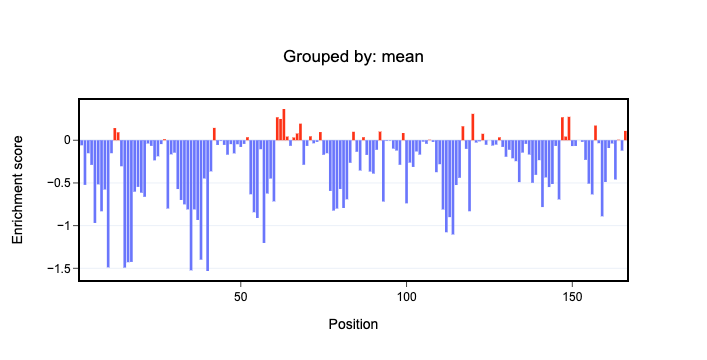

In [20]:
'''    import os
    directory = os.getcwd()
    new_directory = directory.replace('tests', 'main')
    os.chdir(new_directory)

    from code_create_objects import (hras_RBD)
    os.chdir(directory)
    plot_mean_plotly(hras_RBD())'''

In [19]:
def plot_mean_plotly(
    self, mode='mean', output_html: Union[None, str, Path] = None, **kwargs
):
    '''
    Generate a plotlu mean plot.

    Parameters
    ----------
    self : object from class *Screen*

    mode : str, default 'mean'
        Specify what enrichment scores to show. If mode = 'mean', it will show the mean of 
        each position. If mode = 'A', it will show the alanine substitution profile. Can be 
        used for each amino acid. Use the one-letter code and upper case.
        
    output_html : str, default None
        If you want to export the generated graph into html, add the path and name of the file.
        Example: 'path/filename.html'.
        
    **kwargs : other keyword arguments

    Returns
    ----------
    fig : plotly object

    '''
    # update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['figsize'] = kwargs.get('figsize', (4.5, 3))
    temp_kwargs['x_label'] = kwargs.get('x_label', 'Position')
    temp_kwargs['y_label'] = kwargs.get('y_label', 'Enrichment score')
    temp_kwargs['title'] = kwargs.get('title', 'Filtered by: {}'.format(mode))
    temp_kwargs['color_gof'] = kwargs.get('color_gof', '#FD3216')
    temp_kwargs['color_lof'] = kwargs.get('color_lof', '#6A76FC')

    # Chose mode:
    df = _select_grouping(self, mode)

    # Calculate colors
    df['Color'] = df.apply(
        code_utils._color_data,
        axis=1,
        args=(temp_kwargs['color_gof'], temp_kwargs['color_lof'])
    )

    # Create figure
    #fig = px.bar(data_frame=df, x='Position', y='Score', color='Color')
    #px.bar was switching colors when the first value of Score was negative

    fig = go.Figure(
        data=[
            go.Bar(
                x=df['Position'],
                y=df['Score'],
                marker_color=df['Color'],
                marker_line_width=0,
            )
        ]
    )

    # Style
    pio.templates.default = "plotly_white"

    # UPDATE AXES
    fig.update_xaxes(
        title_text=temp_kwargs['x_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True,
    )
    fig.update_yaxes(
        title_text=temp_kwargs['y_label'],
        showline=True,
        linewidth=2,
        linecolor='black',
        ticks="outside",
        mirror=True,
    )

    # Color and width of bars
    #fig.update_traces(marker_line_width=0, )

    # Layout and title parameters https://plotly.com/python/figure-labels/
    fig.update_layout(
        width=temp_kwargs['figsize'][0] * 120,
        height=temp_kwargs['figsize'][1] * 120,
        showlegend=False,
        font=dict(family="Arial, monospace", size=12, color="black"),
        title={
            'text': temp_kwargs['title'], 'xanchor': 'center', 'yanchor': 'top',
            'x': 0.5
        }
    )

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})


def _select_grouping(self, mode):
    '''
    Choose the subset of substitutions based on mode input.
    For example, if mode=='A', then return data for Alanine.

    '''
    # convert to upper case
    mode = mode.upper()

    # Select grouping
    if mode == 'MEAN':
        df = self.dataframe.groupby('Position', as_index=False).mean()
    else:
        df = self.dataframe.loc[self.dataframe['Aminoacid'] == mode].copy()

    return df

## 3D

In [159]:
def plot_scatter_3D_plotly(
    self,
    mode='mean',
    pdb_path=None,
    df_coordinates=None,
    position_correction=0,
    chain='A',
    squared=False,
    output_html: Union[None, str, Path] = None,
    **kwargs
):
    """
    Generates a 3-D scatter plot of the x,y,z coordinates of the C-alpha atoms
    of the residues, color coded by the enrichment scores. PDBs may have atoms
    missing, you should fix the PDB before using this method. Use matplotlib
    for interactive plot.

    Parameters
    -----------
    self : object from class *Screen*
        **kwargs : other keyword arguments.

    mode : str, default 'mean'
        Specify what enrichment scores to use. If mode = 'mean', it will use the mean of
        each position to classify the residues. If mode = 'A', it will use the Alanine substitution profile.
        Can be used for each amino acid. Use the one-letter code and upper case.

    pdb : str, default None
        User should specify the path PDB chain.

    df_coordinates: pandas dataframe, default None
        If no pdb is included, the user must pass the 3-D coordinates of the residues to plot.
        In here you have more flexibility and you can select other atoms besides the C-alpha.

    position_correction : int, default 0
        If the pdb structure has a different numbering of positions than you dataset,
        you can correct for that. If your start_position = 2, but in the PDB that same residue
        is at position 20, position_correction needs to be set at 18.

    chain : str, default 'A'
        Chain of the PDB file to get the coordinates and SASA from.

    squared : boolean, False
        If this parameter is True, the algorithm will center the data, and plot the square value of the
        distance.

    output_html : str, default None
        If you want to export the generated graph into html, add the path and name of the file.
        Example: 'path/filename.html'.

    **kwargs : other keyword arguments

    Returns
    ---------
    fig : plotly object

    """

    # update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['x_label'] = kwargs.get('x_label', 'x (Å)')
    temp_kwargs['y_label'] = kwargs.get('y_label', 'y (Å)')
    temp_kwargs['z_label'] = kwargs.get('z_label', 'z (Å)')
    
    # Get Scores and colors
    df = _color_3D_scatter(
        self.dataframe, mode, temp_kwargs['lof'], temp_kwargs['gof']
    )

    # If coordinates is not an input, get it from the pdb
    if df_coordinates is None:
        df_coordinates = _parse_pdbcoordinates(
            self, pdb_path, position_correction, chain
        )

    # Plot figure
    x, y, z = ('x', 'y', 'z')
    if squared is True:
        x, y, z = ('x_cent', 'y_cent', 'z_cent')
    fig = px.scatter_3d(
        df_coordinates,
        x=x,
        y=y,
        z=z,
        color=df['Score'],
        color_continuous_scale=_matplotlib_to_plotly(temp_kwargs['colormap'], ),
        range_color=temp_kwargs['colorbar_scale']
    )

    # update axes
    fig = _update_axes(fig, temp_kwargs)

    # for the clickable part
    fig.update_traces(
        hovertext=df['Position'], hovertemplate='Position: %{hovertext}'
    )
    # title
    fig = _update_layout(fig, temp_kwargs)

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    # show only if asked
    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})


def _update_layout(fig, temp_kwargs):
    fig.update_layout(
        font=dict(family="Arial, monospace", size=12, color="black"),
        title={
            'text': temp_kwargs['title'], 'xanchor': 'center', 'yanchor': 'top',
            'x': 0.5
        },
        coloraxis_colorbar=dict( # modify colorbar properties
        title = 'Fitness',
        len=0.4,
        thickness=15,
        outlinewidth=2,
        outlinecolor='rgb(0,0,0)',
        showticklabels=True,
        )
    )
    return fig


def _update_axes(fig, temp_kwargs):
    '''Separeated this portion of the code because it is clumsy. It changes the
    axes looks.'''
    # Layout and title parameters https://plotly.com/python/figure-labels/
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title_text=temp_kwargs['x_label'],
                showline=True,
                linewidth=2,
                linecolor='black',
                ticks="outside",
                mirror=True,
                backgroundcolor='#9467bd',
            ),
            yaxis=dict(
                title_text=temp_kwargs['y_label'],
                showline=True,
                linewidth=2,
                linecolor='black',
                ticks="outside",
                mirror=True,
                backgroundcolor='#9467bd',
            ),
            zaxis=dict(
                title_text=temp_kwargs['z_label'],
                showline=True,
                linewidth=2,
                linecolor='black',
                ticks="outside",
                mirror=True,
                backgroundcolor='#9467bd',  #change the color of axis
            )
        )
    )
    return fig

# PDB properties

In [12]:
def plot_scatter_3D_pdbprop_plotly(
    self,
    plot=['Distance', 'SASA', 'log B-factor'],
    mode='mean',
    pdb_path=None,
    custom=None,
    position_correction=0,
    chain='A',
    output_df=False,
    output_html: Union[None, str, Path] = None,
    **kwargs
):
    """
    Generates a 3-D scatter plot of different properties obtained from the PDB.
    PDBs may have atoms missing, you should fix the PDB before using this
    method. We recommend you use matplotlib for interactive plot.

    Parameters
    -----------
    self : object from class *Screen*
        **kwargs : other keyword arguments.

    plot : list, default ['Distance', 'SASA', 'log B-factor']
        List of 3 elements to plot. Other options are 'Score' and Custom. If custom, add the
        label to the third element of the list ie ['Distance', 'SASA', 'Conservation'].

    mode : str, default 'mean'
        Specify what enrichment scores to use. If mode = 'mean', it will use the mean of
        each position to classify the residues. If mode = 'A', it will use the Alanine substitution profile. 
        Can be used for each amino acid. Use the one-letter code and upper case.

    pdb_path : str, default None
        User should specify the path PDB.

    custom : list or dataframe or np.array, default None
        If you want to add a custom dataset to plot, use custom. On the parameter
        plot, the 3rd item of the list will be the label for your custom dataset.

    df_color : pandas dataframe, default None
        The color of each residue can also be included. You must label that label column.

    color_by_score : boolean, default True
        If set to False, the points in the scatter will not be colored based on the enrichment score.

    position_correction : int, default 0
        If the pdb structure has a different numbering of positions than you dataset,
        you can correct for that. If your start_position = 2, but in the PDB that same residue
        is at position 20, position_correction needs to be set at 18.

    chain : str, default 'A'
        Chain of the PDB file to get the coordinates and SASA from.

    output_df : boolean, default False
        If true, this method will return the dataframe with the data.
        Set return_plot_object for this to work.

    output_html : str, default None
        If you want to export the generated graph into html, add the path and name of the file.
        Example: 'path/filename.html'.

    **kwargs : other keyword arguments

    Returns
    ---------
    fig : plotly object

    df_items : pandas dataframe
        Contains the plotted data. Needs to have output_df set to true.

    """
    # Update kwargs
    temp_kwargs = copy.deepcopy(code_kwargs.kwargs())
    temp_kwargs.update(kwargs)
    temp_kwargs['x_label'] = kwargs.get('x_label', plot[0])
    temp_kwargs['y_label'] = kwargs.get('y_label', plot[1])
    temp_kwargs['z_label'] = kwargs.get('z_label', plot[2])

    # Get Scores and colors
    df_scores = _color_3D_scatter(
        self.dataframe, mode, temp_kwargs['lof'], temp_kwargs['gof']
    )

    # If coordinates is not an input, get it from the pdb
    df_items = _parse_pdbcoordinates(
        self, pdb_path, position_correction, chain, sasa=True
    )

    # Add scores
    df_items['Score'] = list(df_scores['Score'])

    # Custom data
    if custom is not None:
        df_items[plot[2]] = custom

        # Plot figure
    fig = px.scatter_3d(
        df_items,
        x=plot[0],
        y=plot[1],
        z=plot[2],
        color='Score',
        color_continuous_scale=_matplotlib_to_plotly(temp_kwargs['colormap'], ),
        range_color=temp_kwargs['colorbar_scale'],
    )

    # update axes
    fig = _update_axes(fig, temp_kwargs)

    # for the clickable part
    fig.update_traces(
        hovertext=df_items['Position'], hovertemplate='Position: %{hovertext}'
    )
    # title
    fig = _update_layout(fig, temp_kwargs)

    # save fig to html
    _save_html(fig, output_html)

    # return plotly object
    if temp_kwargs['return_plot_object']:
        return fig

    # show only if asked
    if temp_kwargs['show']:
        fig.show(config = {'displayModeBar': False})

    if output_df:
        return df_items, df_scores

## Aux functions (stolen from code_3D)

In [13]:
def _color_3D_scatter(df, mode, lof, gof):
    """
    Color the data points by enrichment scores.

    Parameters
    -----------
    df : pandas dataframe
        The input is a dataframe that has colum with ['Position', 'Aminoacid', 'Score'].

    mode : str
        Specify what enrichment scores to use. If mode = 'mean', it will use the mean of
        each position to classify the residues. If mode = 'A', it will use the Alanine substitution profile.
        Can be used for each amino acid. Use the one-letter code and upper case.

    gof : int, default is 1
        cutoff for determining gain of function mutations based on mutagenesis data.

    lof : int, default is -1
        cutoff for determining loss of function mutations based on mutagenesis data.

    Returns
    ---------
    df_grouped: pandas dataframe
        New dataframe with added column of ['Color'] and the ['Score'] values of the
        mode you chose.

    """

    # Copy df
    df_grouped = df.copy()

    # Select grouping.
    if mode == 'mean':
        df_grouped = df_grouped.groupby(['Position'], as_index=False).mean()
    else:
        df_grouped = df_grouped.loc[df_grouped['Aminoacid'] == mode]

    # Select colors based on Score values
    df_grouped['Color'] = 'green'
    df_grouped.loc[df_grouped['Score'] < lof, 'Color'] = 'blue'
    df_grouped.loc[df_grouped['Score'] > gof, 'Color'] = 'red'

    return df_grouped


def _centroid(df):
    '''
    Find center of x,y,z using centroid method. 
    The input is a dataframe with columns x, y, z.
    Returns the center of each of the three dimensions
    '''
    return df['x'].mean(), df['y'].mean(), df['z'].mean()


def _parse_pdbcoordinates(
    self, pdb_path, position_correction, chain, sasa=False
):
    '''parse coordinate of CA atoms. Will also return the bfactor and SASA using freesasa.
    If PDB is missing atoms, it can handle it.'''

    # Get structure from PDB
    structure = PDBParser().get_structure('pdb', pdb_path)

    coordinates = []
    commands = []
    bfactors = []
    positions_worked = []  # positions present in pdb

    # Iterate over each CA atom and geet coordinates
    for i in np.arange(self.start_position + position_correction,
                       self.end_position + position_correction):
        # first check if atom exists
        try:
            structure[0][chain][int(i)].has_id("CA")
            # Get atom from pdb and geet coordinates
            atom = list(structure[0][chain][int(i)]["CA"].get_vector()) + [i]
            coordinates.append(atom)
            # Get SASA command for each residue and bfactor
            residue = "s{}, chain {} and resi {}".format(str(i), chain, str(i))
            commands.append(residue)
            bfactor = (structure[0][chain][int(i)]["CA"].get_bfactor())
            bfactors.append(np.log10(bfactor))
            positions_worked.append(i)
        except:
            print("residue {} not found".format(str(i)))
            coordinates.append([np.nan, np.nan, np.nan, i])

    # Convert to df
    df_coordinates = pd.DataFrame(
        columns=['x', 'y', 'z', 'Position'], data=coordinates
    )

    # Center data
    x, y, z = _centroid(df_coordinates)
    df_coordinates['x_cent'] = (df_coordinates['x'] - x).abs()**2
    df_coordinates['y_cent'] = (df_coordinates['y'] - y).abs()**2
    df_coordinates['z_cent'] = (df_coordinates['z'] - z).abs()**2
    df_coordinates['Distance'] = df_coordinates['x_cent'] + \
        df_coordinates['y_cent']+df_coordinates['z_cent']

    # Add sasa values
    if sasa:
        # Get structure for SASA
        structure_sasa = freesasa.Structure(pdb_path)
        result = freesasa.calc(structure_sasa)
        # Calculate sasa
        sasa = freesasa.selectArea(commands, structure_sasa, result)
        df_sasa = pd.DataFrame(columns=['SASA'], data=sasa.values())
        df_sasa['log B-factor'] = bfactors
        df_sasa['Position'] = positions_worked

        # Merge
        df_coordinates = df_coordinates.merge(
            df_sasa, how='outer', on='Position'
        )

    return df_coordinates


def _matplotlib_to_plotly(cmap, pl_entries=255):
    '''convert a matplotlib colorscale into plotly rgb format'''
    h = 1.0 / (pl_entries - 1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k * h)[:3]) * 255))
        pl_colorscale.append([k * h, 'rgb' + str((C[0], C[1], C[2]))])

    return pl_colorscale